In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imageio.v3 as iio
import skimage as ski
import cv2
import os
from scipy.optimize import curve_fit

from scipy.ndimage import label, center_of_mass 

In [6]:
from ipynb.fs.full.phase_unwrap import phase_unwrap, _wrapToPi
import matplotlib.colors as mcolors

In [7]:
import glob

In [9]:
def rms(data):
    return np.sqrt(np.mean(np.square(data)))

In [85]:
# import cv2

# # Open the video file
# video_path = "wavefront_video_4000.mp4"  # Change this to your video file path
# cap = cv2.VideoCapture(video_path)

# # Read the first frame
# ret, frame = cap.read()

# if ret:
#     # Save the first frame as an image
#     cv2.imwrite("wavefront_first_frame.jpg", frame)
#     plt.imshow(frame)
#     print("First frame saved as 'wavefront_first_frame02.jpg'")
# else:
#     print("Failed to read the first frame.")

# # Release the video capture object
# cap.release() 

### From the wavefronts saved (in .npy format), taking a pixel in random and analysing it's values with time

In [10]:
%cd D:\Europhotonics Masters\MATLAB\LAM\21March\testt\2700 frames analysis\ff_frames_npy format

D:\Europhotonics Masters\MATLAB\LAM\21March\testt\2700 frames analysis\ff_frames_npy format


0 iterations complete
100 iterations complete
200 iterations complete
300 iterations complete
400 iterations complete
500 iterations complete
600 iterations complete
700 iterations complete
800 iterations complete
900 iterations complete
1000 iterations complete
1100 iterations complete
1200 iterations complete
1300 iterations complete
1400 iterations complete
1500 iterations complete
1600 iterations complete
1700 iterations complete
1800 iterations complete
1900 iterations complete
2000 iterations complete
2100 iterations complete
2200 iterations complete
2300 iterations complete
2400 iterations complete
2500 iterations complete
2600 iterations complete


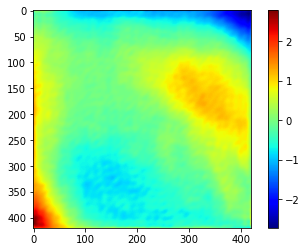

In [11]:
# Using the npy data, to load and plot the images back:
y= np.random.randint(0,420)
x= np.random.randint(0,420)
pixel1=[]

for i in range(2700):
    f = np.load(f"frame_{i:04d}.npy", allow_pickle=True)
    pixel1.append(f[y,x])
    if i%100==0:
        print(i, "iterations complete")
plt.imshow(f, cmap='jet')
plt.colorbar()

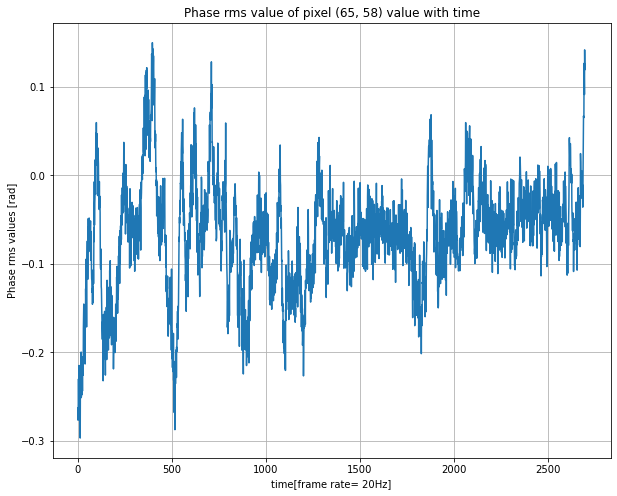

Standard deviation:  [0.06160074, 0.043350697, 0.030989604, 0.024221366, 0.021804327, 0.011004425, 0.0031813139, 0.0020820606, 0.001317647, 0.0005877464]


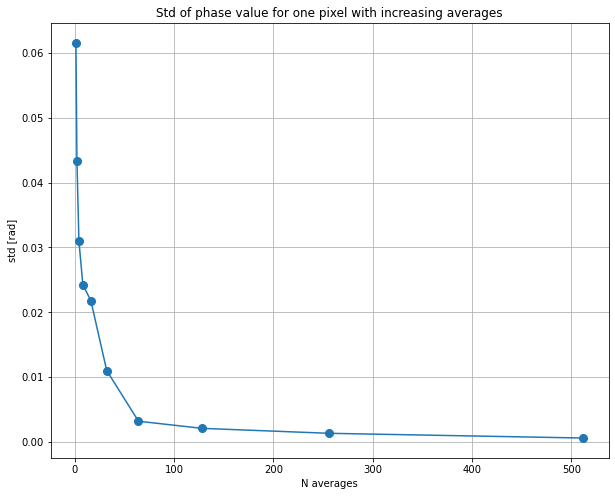

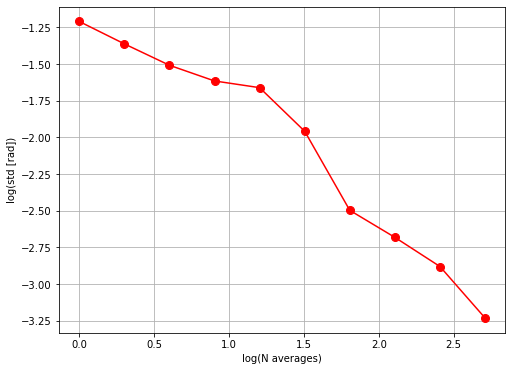

In [12]:
plt.figure(figsize=(10,8))
plt.plot(pixel1)
plt.grid()
plt.title(f'Phase rms value of pixel {y,x} value with time')
plt.ylabel('Phase rms values [rad]')
plt.xlabel('time[frame rate= 20Hz]')
plt.show()
# avg = np.mean(pixel)
stdd = [np.std(pixel1)]
N = len(pixel1)
data = np.copy(pixel1)
new_data = []

while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
print('Standard deviation: ',stdd)
plt.figure(figsize=(10,8))
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.grid()
plt.title('Std of phase value for one pixel with increasing averages')
plt.xlabel('N averages')
plt.ylabel('std [rad]')
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o', color='red', markersize=8)
# plt.ylim(-2.0,0.0)
plt.grid('True')
plt.ylabel('log(std [rad])')
plt.xlabel('log(N averages)')
plt.show()

Standard deviation (in nm):  [6.1961675  4.36047    3.117118   2.4363284  2.1932085  1.1068902
 0.3199954  0.20942599 0.13253674 0.05911901]


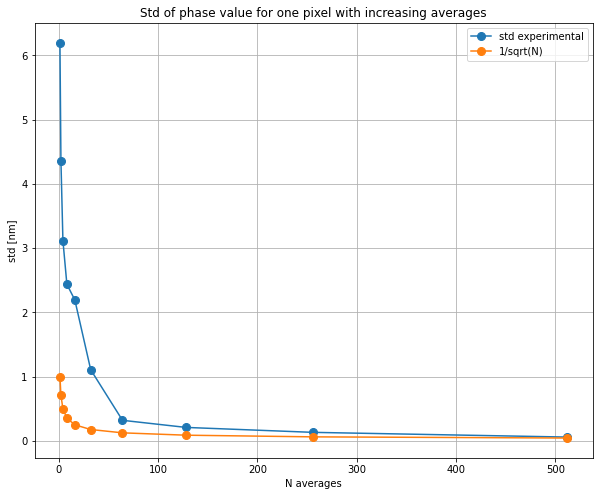

In [13]:
# std until now is in rad where phi = (2*pi/lambda)*path_difference
wavelength = 632 # in nm
std_opd = np.array(stdd)* (wavelength/(2*np.pi))  # in nm
print('Standard deviation (in nm): ',std_opd)
plt.figure(figsize=(10,8))
x1 = np.linspace(0,len(std_opd)-1,len(std_opd))
x_axis1 = 2**x1
plt.plot(x_axis1, std_opd,marker='o', markersize=8, label='std experimental')
plt.plot(x_axis1, 1/np.sqrt(x_axis1),marker='o', markersize=8, label='1/sqrt(N)')
plt.grid()
plt.title('Std of phase value for one pixel with increasing averages')
plt.xlabel('N averages')
plt.ylabel('std [nm]')
plt.legend()
plt.show()

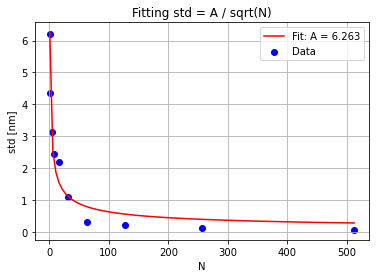

For std = 0.1nm, corresponding N = 3922
For std = 0.01nm, corresponding N = 392191
For std = 0.001nm, corresponding N = 39219087


In [14]:
N = x_axis1;
y = std_opd

# Define the model function y = A / sqrt(N)
def model(N, A):
    return A / np.sqrt(N)

# Perform curve fitting
A_opt, _ = curve_fit(model, N, y, p0=[1])  # Initial guess A=1
A_fit = A_opt[0]
# Generate fitted curve
N_fit = np.linspace(min(N), max(N), 100)  # Smooth range for plotting
y_fit = model(N_fit, A_fit)

# Plot results
plt.scatter(N, y, color='blue', label='Data')  # Original data points
plt.plot(N_fit, y_fit, 'r-', label=f'Fit: A = {A_fit:.3f}')  # Fitted curve
plt.xlabel('N')
plt.ylabel('std [nm]')
plt.legend()
plt.grid()
plt.title('Fitting std = A / sqrt(N)')
plt.show()

# from this fit now let's try to find the the values of N for which I could reach 1nm, 100pm, 10pm, 1pm ?
y_target = [0.1, 0.01, 0.001]   # Target std values
N_target = (A_fit/y_target)**2   # Compute corresponding N
print(f'For std = {y_target[0]}nm, corresponding N = {round(N_target[0])}')
print(f'For std = {y_target[1]}nm, corresponding N = {round(N_target[1])}')
print(f'For std = {y_target[2]}nm, corresponding N = {round(N_target[2])}')

### For multiple independent pixels


In [22]:
y= np.random.randint(0,420,size=10)
x= np.random.randint(0,420, size=10)
pixel=np.empty((10,2700))

for i in range(10):
    for j in range(2700):
        f = np.load(f"frame_{j:04d}.npy", allow_pickle=True)
        pixel[i,j] = f[y[i],x[i]]
        if j%500==0:
            print(j, "iterations complete")
plt.imshow(f, cmap='jet')
plt.colorbar()

In [24]:
stdd = [np.std(pixel[0,:])]
N = 2700
data = np.copy(pixel[0,:])
new_data = []
print(len(pixel[0,:]))
while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1,figsize=(10,8))
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.grid()

plt.figure(2,figsize=(8,6))
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o', markersize=8)
plt.grid()
plt.show()

In [23]:
# avg = np.mean(pixel)
stdd = [np.std(pixel[0,:])]
N = 2700
data = np.copy(pixel[0,:])
new_data = []

while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1,figsize=(10,8))
plt.plot(x_axis1, stdd,marker='o', markersize=8)

plt.figure(2,figsize=(8,6))
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o', markersize=8)

stdd = [np.std(pixel[1,:])]
N = 2700
data = np.copy(pixel[1,:])
new_data = []
while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(2)
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o', markersize=8)

stdd = [np.std(pixel[2,:])]
N = 2700
data = np.copy(pixel[2,:])
new_data = []
while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(2)
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o', markersize=8)

stdd = [np.std(pixel[3,:])]
N = 2700
data = np.copy(pixel[3,:])
new_data = []
while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(2)
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o',markersize=8)

stdd = [np.std(pixel[4,:])]
N = 2700
data = np.copy(pixel[4,:])
new_data = []

while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(2)
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o',markersize=8)

stdd = [np.std(pixel[5,:])]
N = 2700
data = np.copy(pixel[5,:])
new_data = []

while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(2)
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o',markersize=8)

stdd = [np.std(pixel[6,:])]
N = 2700
data = np.copy(pixel[6,:])
new_data = []

while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(2)
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o',markersize=8)

stdd = [np.std(pixel[7,:])]
N = 2700
data = np.copy(pixel[7,:])
new_data = []

while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(2)
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o',markersize=8)



stdd = [np.std(pixel[8,:])]
N = 2700
data = np.copy(pixel[8,:])
new_data = []

while N>=10:
    for i in range(N//2):
        a = np.mean([data[i], data[N-(i+1)]])
        new_data.append(a)
    stdd.append(np.std(new_data))
    N = len(new_data)
    data = np.copy(new_data)
    new_data.clear()
x1 = np.linspace(0,len(stdd)-1,len(stdd))
x_axis1 = 2**x1
plt.figure(1)
plt.plot(x_axis1, stdd,marker='o', markersize=8)
plt.figure(1)
plt.grid('True')
plt.title('Std of phase value for independent pixels with increasing averages')
plt.xlabel('N averages')
plt.ylabel('std [rad]')

plt.figure(2)
plt.grid('True')
plt.plot(np.log10(x_axis1), np.log10(stdd),marker='o',markersize=8)
plt.ylabel('log(std [rad])')
plt.xlabel('log(N averages)')
plt.show()

In [21]:
# # The same as above but using memory map
# # Step 1: Memory-map file
# filename = os.path.abspath("pixel_01.dat")
# num_frames = 2700  # Adjust based on actual frames
# height, width = 414, 344  # Adjust based on wavefront size

# pixels_4000 = np.memmap(filename, dtype=np.float32, mode='w+', shape=(num_frames))

# # Step 2: Compute and directly store in memory-mapped file
# y= np.random.randint(0,414)
# x= np.random.randint(0,344)
# cap = cv2.VideoCapture("wavefront_video_4000.mp4")
# frame_count=0

# while cap.isOpened():
#     ret,frame = cap.read()  # read a frame
#     if not ret:
#         break     # Exit loop if no frame left
#     # Convert frame to grayscale
#     gray_scale= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     # Convert to float and normalize
#     frame1= gray_scale.astype(np.float32)/255.0  # Normalize to range [0,1]
#     image_crop= frame1[:415,:345] #Cropping the size to remove the boundary discontinuity
#     pixels_4000[frame_count] = image_crop[y,x]
#     frame_count+=1
#     if frame_count%100==0:
#         print(frame_count,'iterations complete')
# cap.release() # Release video capture